# Data Cleaning Notebook for Dengue Transfer Learning Project

## Task

Conduct EDA for TensorFlow transfer learning pipeline to forecast **weekly dengue cases** (`total_cases`) from 22 multivariate weather/environmental features.

### Dataset
Dengue ML datasets track environmental and temporal factors influencing Aedes mosquito breeding and virus transmission in tropical regions like San Juan and Iquitos.

- #### Temporal Features
    - **city**: Location identifier (e.g., 'sj' for San Juan, 'iq' for Iquitos)—captures city-specific mosquito/dengue patterns.
    - **year, weekofyear, week_start_date**: Time granularity for seasonality; dengue peaks during rainy seasons (weekofyear critical for lagged effects).

- #### Vegetation Indices (NDVI)
    - **ndvi_ne, ndvi_nw, ndvi_se, ndvi_sw**: Normalized Difference Vegetation Index by city quadrant. Higher NDVI indicates lush vegetation providing mosquito shade/breeding sites; key for Aedes habitat detection via satellite.

- #### Precipitation \& Water
    - **precipitation_amt_mm**: Rainfall amount—creates standing water breeding sites.
    - **reanalysis_precip_amt_kg_per_m2, reanalysis_sat_precip_amt_mm**: Reanalysis (modeled) precipitation variants confirming observed rain.
    - **station_precip_mm**: Ground station measurements—most direct rain proxy.

- #### Temperature Metrics
    - **reanalysis_air_temp_k, reanalysis_avg_temp_k, reanalysis_max_air_temp_k, reanalysis_min_air_temp_k**: Reanalysis temps in Kelvin; optimal Aedes range 26-32°C accelerates larval development/virus replication.
    - **station_avg_temp_c, station_max_temp_c, station_min_temp_c**: Station temps in Celsius—ground truth validation.
    - **station_diur_temp_rng_c**: Diurnal range; wider swings stress mosquitoes.
    - **reanalysis_tdtr_k**: Temperature diurnal temperature range (reanalysis).

- #### Humidity \& Moisture
    - **reanalysis_dew_point_temp_k**: Dew point—direct humidity proxy; high values (>20°C) favor mosquito survival.
    - **reanalysis_relative_humidity_percent**: Relative humidity %—critical for egg/larval viability.
    - **reanalysis_specific_humidity_g_per_kg**: Absolute moisture content.


### Notebook sections for the second project notebook (Data Cleaning)
1. Get Data
2. Data Cleaning
4. Feature Selection (TBC poss notebook 03)
5. Feature Engineering (TBC poss notebook 03)
6. Benchmark Model
7. Model Tuning  (TBC)
8. Model Evaluation  (TBC, poss notebook 03)

In [1]:
import sys
import os
from pathlib import Path
from typing import List, Tuple, Any, Dict
import gc

# Set one level up as project root|
if os.path.abspath("..") not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))
    
from src.config import ProjectConfig  # project config file parser
from src.utils.eda import value_streaks, top_correlations
from src.utils.visualizations import compute_correlations_matrix, \
                display_distributions, random_color, random_colormap, \
                display_timeseries

import pandas as pd
import numpy as np
import random
import time
from datetime import timedelta

from src.preprocessing.clean import cap_outliers, drop_nan_rows, \
                                    median_groupwise_impute

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# from matplotlib.axis import Axis
# from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
import seaborn as sns

In [2]:
cnfg = ProjectConfig.load_configuration()
PATH_TO_RAW_DATA = cnfg.data.dirs["raw"]
FILE_TRAIN_RAW= cnfg.data.files["features_train"]
FILE_TEST_RAW = cnfg.data.files["features_test"]
FILE_LABELS_RAW = cnfg.data.files["labels_train"]
TARGET = cnfg.preprocess.feature_groups["target"]
ENV_FEAT_PREFIX = cnfg.preprocess.feature_groups["env_prefixes"]
CITYGROUP_FEAT = cnfg.preprocess.feature_groups["city"]
WEEK_FEAT = cnfg.preprocess.feature_groups["week"]

### Get Data

In [3]:
df_train_raw = pd.read_csv(PATH_TO_RAW_DATA / FILE_TRAIN_RAW, parse_dates=["week_start_date"])
df_test_raw = pd.read_csv(PATH_TO_RAW_DATA / FILE_TEST_RAW, parse_dates=["week_start_date"])
df_labels_raw = pd.read_csv(PATH_TO_RAW_DATA / FILE_LABELS_RAW)
list_raw_df = [df_train_raw, df_test_raw, df_labels_raw]
env_features = [f for f in df_train_raw if f.startswith(tuple(ENV_FEAT_PREFIX))]

In [4]:
df_train_raw = pd.read_csv(PATH_TO_RAW_DATA / FILE_TRAIN_RAW, parse_dates=["week_start_date"])
# df_test_raw = pd.read_csv(PATH_TO_RAW_DATA / FILE_TEST_RAW, parse_dates=["week_start_date"])
df_labels_raw = pd.read_csv(PATH_TO_RAW_DATA / FILE_LABELS_RAW)
# list_raw_df = [df_train_raw, df_test_raw, df_labels_raw]
# for df in list_raw_df:
#     display(df.sample(1))  

***To reduce data snooping, slice last entries for both dataset cities***

In [5]:
holdout_pct = 0.05
cities_first_i = df_train_raw.groupby(by=CITYGROUP_FEAT)["week_start_date"].idxmin()  # Series w Start indices
cities_last_i = df_train_raw.groupby(by=CITYGROUP_FEAT)["week_start_date"].idxmax()  # Series w end indices
cities_last_i = (cities_last_i - (cities_last_i - cities_first_i) * holdout_pct).astype(int)  # indice math with Series
period = tuple(slice(cities_first_i[city], cities_last_i[city], 1) for city in cities_last_i.index[::-1])  # Create tuple of slices from 2 Series
df_train_raw_eda = df_train_raw.iloc[np.r_[period]].reset_index()  # apply defuned slices
df_labels_raw_eda = df_labels_raw.iloc[np.r_[period]].reset_index()

## Data Cleaning

# TODO:
- [x] Identify outliers per group
- [x] Cap BEFORE median computation (Winsorization - cap extreme values at specified threshold):
    - 1%/99% threshold for both models 
- [X] Remove rows with over 50% of NaN
- [X] Impute NaNs with the groupwise median.
- [ ] combine north and south NDVIs
- [ ] (OPTIONAL, if outliers still there) Reapply outlier handling AFTER imputation with 5%/95% threshold:
    - larger threshold preserves more of original distribution shape than tail-focussed 1%/99% threshold
    - should not cap much of the data at this stage (CHECK FOR AFFECTED DATAPOINT COUNT)
- [X] 1%/99% caping threshold for TARGET
- [ ] Process zero target value st


### Outlier handling

In [6]:
# TODO remove after cleaning

# def cap_outliers(data: pd.DataFrame, features: List[str]=None,
#                  group_keys: List[str]=None,
#                  lower_cap:float=None, upper_cap:float=None,
#                 output_stats:bool=True) -> Dict[str, Any]:
#     """
#     Perform groupwise Winsorization (percentile clipping) on specified features to handle outliers.
#     Automatically filter environmental features from config prefixes if not specified.
#     :param data: Input pandas DataFrame.
#     :param features: List of column names to clip. Default None auto-selects env features 
#            from prefixes defined in config.yaml.
#     :param group_keys: List of columns to group by for quantile calculation. Default None uses 
#            config.yaml 'city' grouping.
#     :param lower_cap: Lower percentile for clipping (0-1). Default None uses config.yaml 
#            'outlier_perc.lower' (originally 0.01).
#     :param upper_cap: Upper percentile for clipping (0-1). Default None uses config.yaml 
#            'outlier_perc.upper' (originally 0.99).
#     :param output_stats: If True, returns % rows changed per feature. Default True.
#     :return: Dict containing:
#            - 'data': Clipped DataFrame copy (original unchanged)
#            - 'capped_row_prc': Series of % rows clipped per feature (if output_stats=True)
#     """
#     if features is None:
#         features = [f for f in data.columns if f.startswith(
#             tuple(cnfg.preprocess.feature_groups["env_prefixes"]))]
#     if group_keys is None:
#         group_keys = cnfg.preprocess.feature_groups["city"]
#     if lower_cap is None:
#         lower_cap = cnfg.preprocess.outlier_perc["lower"]
#     if upper_cap is None:
#         upper_cap = cnfg.preprocess.outlier_perc["upper"]

#     data_no_outliers = data.copy()
#     data_no_outliers[features] = data_no_outliers.groupby(by=group_keys)[features].transform(
#         lambda group: group.clip(
#             lower=group.quantile(lower_cap), upper=group.quantile(upper_cap)))

#     if output_stats:
#         capped_row_percent = round(
#             ((data[features] != data_no_outliers[features]).sum() / len(data) * 100), 2)
#         return {"data": data_no_outliers,
#                 "capped_row_prc": capped_row_percent}
#     return {"data": data_no_outliers}

In [7]:
intermediate_output = cap_outliers(data=df_train_raw)
df_train_clean = intermediate_output["data"]

In [8]:
intermediate_output["capped_row_prc"]

ndvi_ne                                  15.25
ndvi_nw                                   5.63
ndvi_se                                   3.71
ndvi_sw                                   3.71
precipitation_amt_mm                      2.40
reanalysis_air_temp_k                     2.82
reanalysis_avg_temp_k                     2.82
reanalysis_dew_point_temp_k               2.88
reanalysis_max_air_temp_k                 2.68
reanalysis_min_air_temp_k                 2.61
reanalysis_precip_amt_kg_per_m2           2.88
reanalysis_relative_humidity_percent      2.88
reanalysis_sat_precip_amt_mm              2.40
reanalysis_specific_humidity_g_per_kg     2.88
reanalysis_tdtr_k                         2.82
station_avg_temp_c                        5.01
station_diur_temp_rng_c                   5.01
station_max_temp_c                        3.09
station_min_temp_c                        2.68
station_precip_mm                         2.61
dtype: float64

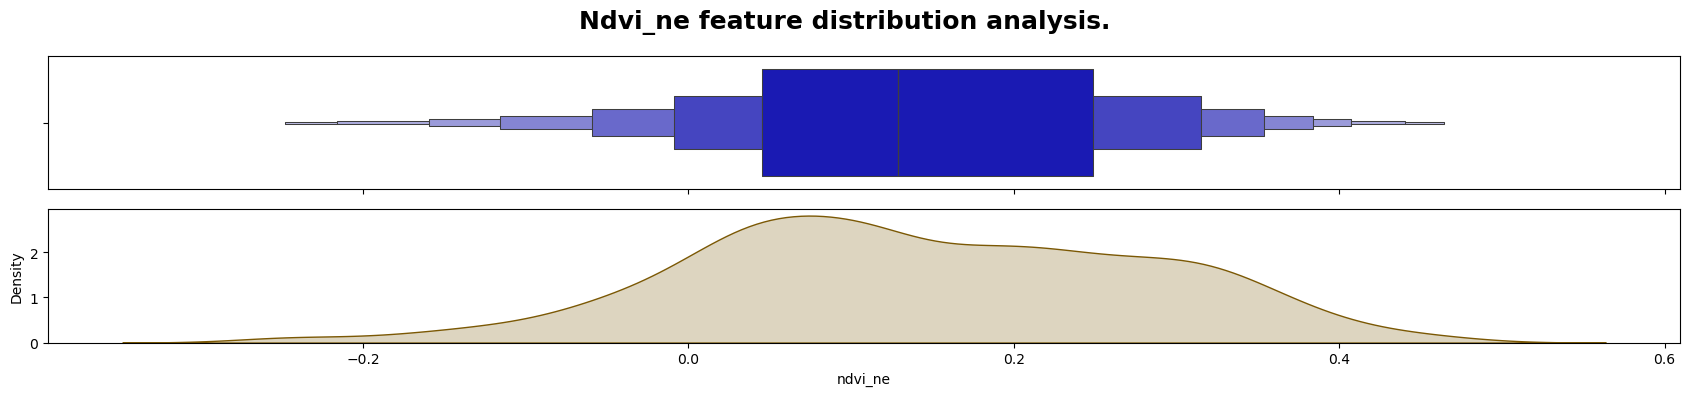

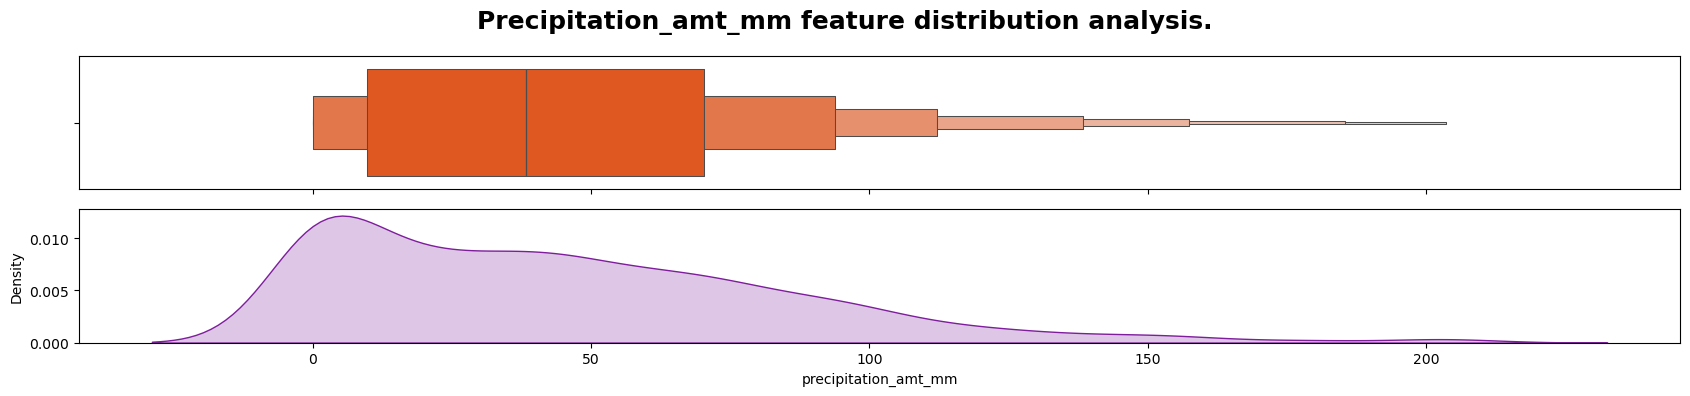

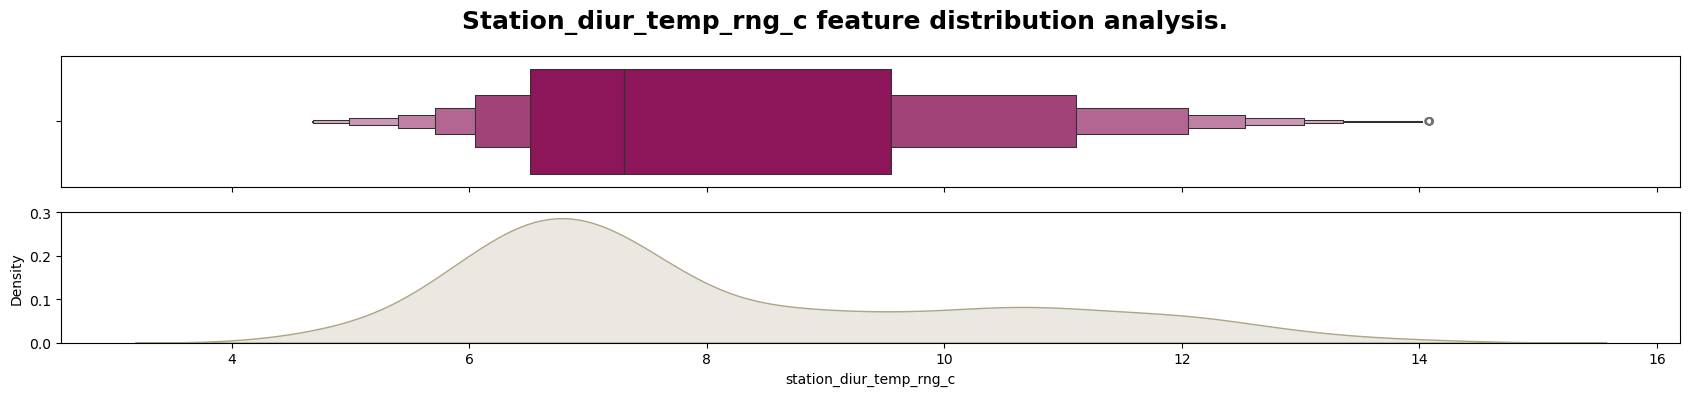

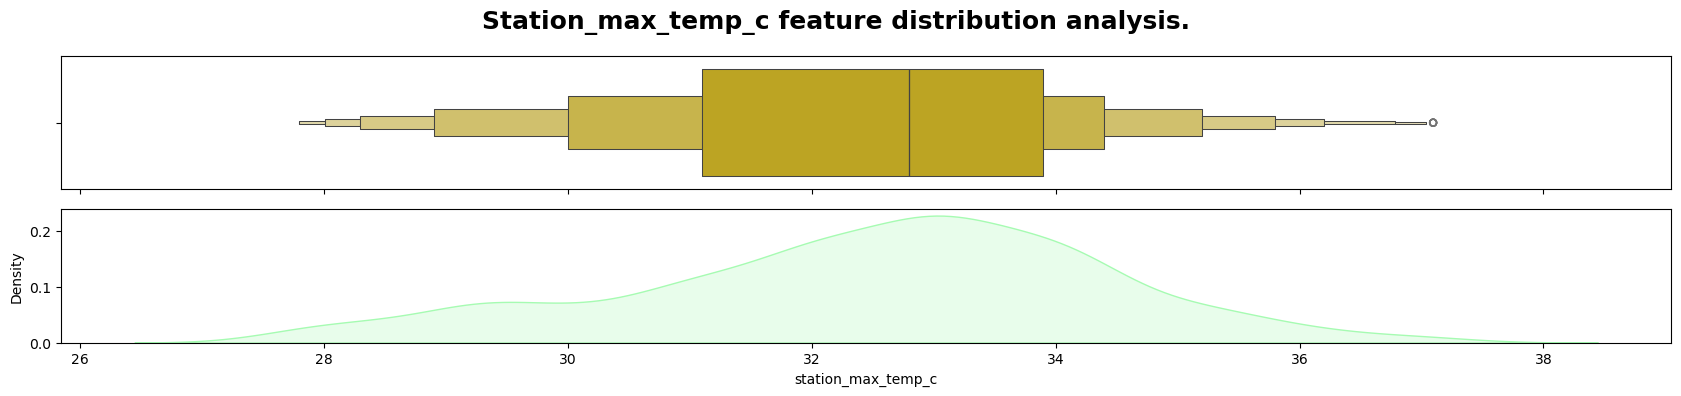

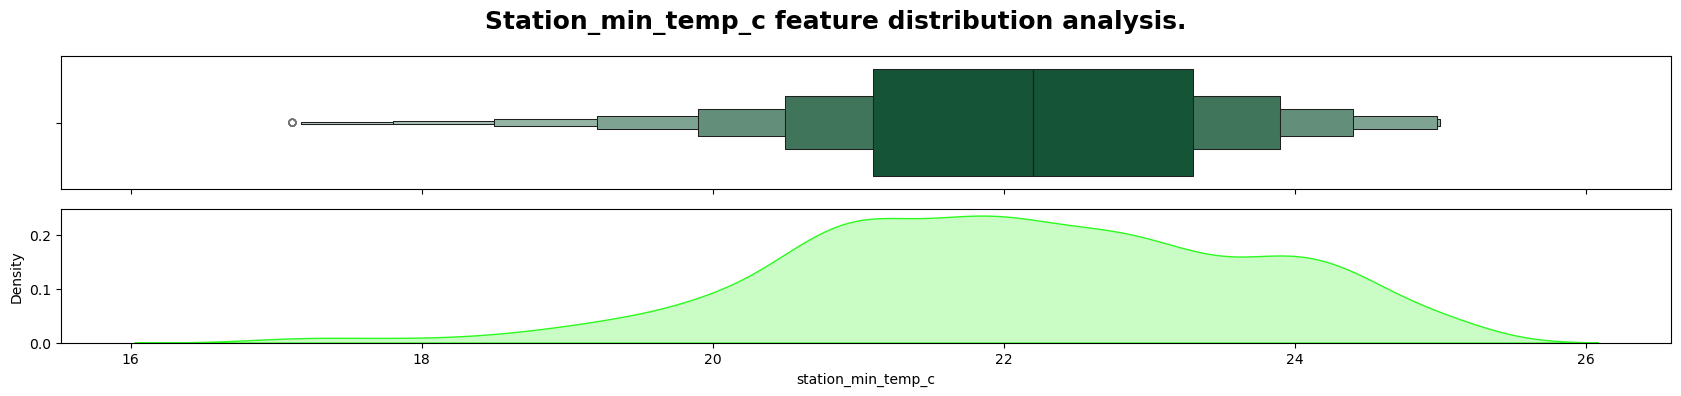

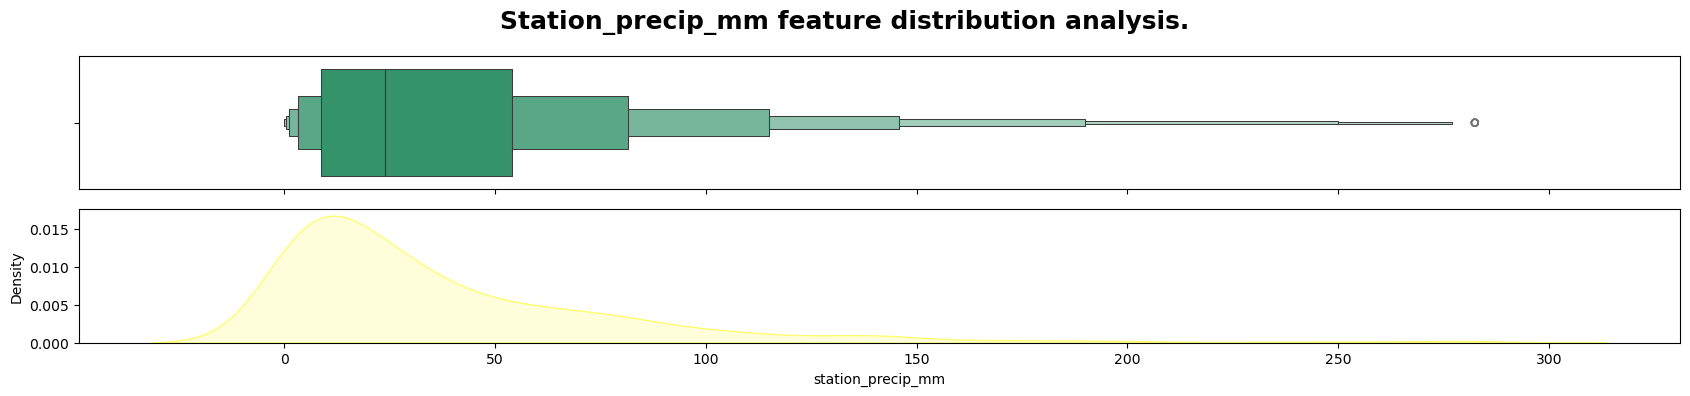

In [10]:
# # Uncomment cell for visual check on new distributions for selected features after outlier cliping/Winsorization 

# selected_distro_EDA_features = ["ndvi_ne", "precipitation_amt_mm", "station_diur_temp_rng_c", "station_max_temp_c",
#        "station_min_temp_c", "station_precip_mm"]
# # selected_distro_EDA_features = [feature for feature in df_train_raw_eda.select_dtypes("float") if not feature.startswith("reanalysis")]  # used for outlier check

# for numeric_feature in selected_distro_EDA_features:
#     display_distributions(data=df_train_clean[selected_distro_EDA_features],
#                           features=[numeric_feature],
#                           title_prefix=numeric_feature)

**Conclusion**:
- Extreme outliers are removed
- Data ranges and variations seam to be credible for tropical climate
- No need to adjust 1%/99% clipping percentailes or conduct second round of cliping/Winsorization
- Adjusted row percentaga is rasonable from ~2-15% (does not exceed 20%)

In [11]:
intermediate_target = cap_outliers(data=df_labels_raw, features=TARGET)
df_labels_clean = intermediate_target["data"]

In [12]:
intermediate_target["capped_row_prc"]

1.37

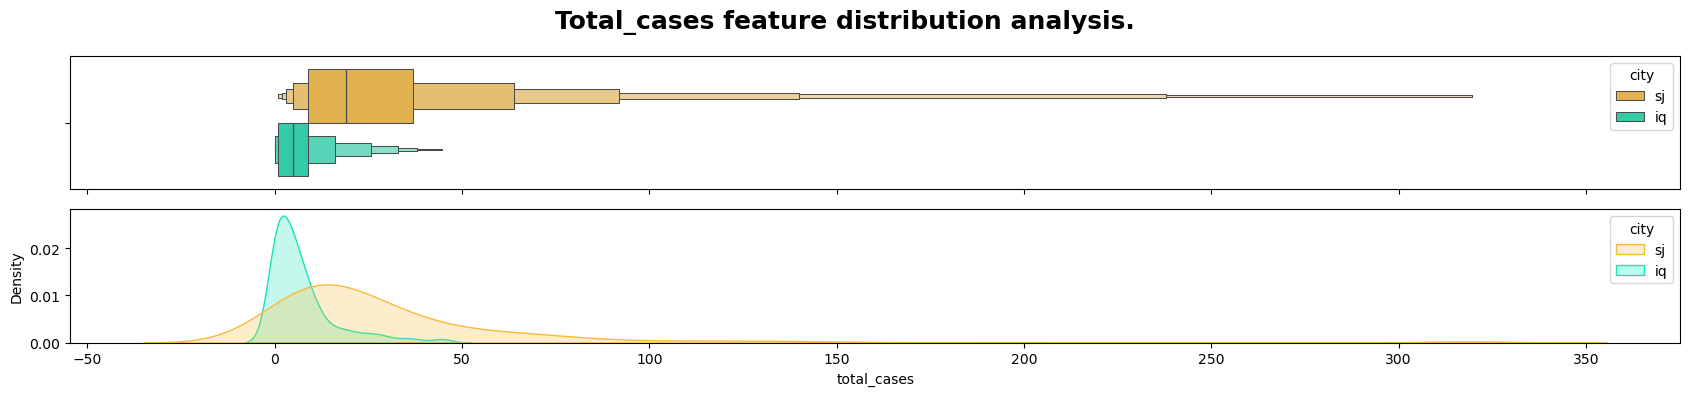

In [24]:
display_distributions(data = df_labels_clean,
                      hue_palette=(CITYGROUP_FEAT, random_colormap()),
                     features=[TARGET], title_prefix=TARGET.capitalize(),
                     )

**Conclusion**:
- Outliers are removed (max 461 in sj -> max of 319)
- No need to adjust 1%/99% clipping percentailes or conduct second round of cliping/Winsorization
- Adjusted row percentaga is low - 1.37%. Potentially acceptable cost for increased model stability.

### NaN handling

- Remove rows with > 50% NaN values:
    - also removes all rowws for `wekofyear` # 53 that do not have observational or analytical data (a likely data collection bug)

In [13]:
# TODO remove after cleaning

# def drop_nan_rows(X: pd.DataFrame, y: pd.Series | None = None,
#                   threshold_percent: float = 0.5):
#     """
#     Drop rows with NaN values exceeding threshold_percent of columns.
    
#     :param X: pandas DataFrame of features.
#     :param y: Optional target array/series. Default None.
#     :param threshold_percent: Min non-null fraction required [0,1]. Default 0.5.
#     :return: Filtered X (and y if provided), both with reset_index().
#     """
#     row_drop_threshold = int(len(X.columns) * threshold_percent)
#     result = X.dropna(thresh=row_drop_threshold)
#     if y is not None:
#         return result.reset_index(), y.iloc[result.index].reset_index()
#     return result.reset_index()

In [14]:
df_train_clean, df_labels_clean = drop_nan_rows(X=df_train_clean, y=df_labels_clean)

In [15]:
# TODO remove after cleaning

# def median_groupwise_impute(X: pd.DataFrame,
#                             group_keys: List[str] = ['city', 'weekofyear']):
#     """
#     Impute NaN values in numeric columns using median within specified group keys.
    
#     :param X: pandas DataFrame containing grouping columns and features to impute.
#     :param group_keys: List of column names for grouping. Default ['city', 'weekofyear'].
#     :return: Copy of input DataFrame with NaNs filled by group-wise medians.
#     """
#     missing_keys = set(group_keys) - set(X.columns)
#     if missing_keys:
#         raise ValueError(f"Missing group keys {missing_keys}")

#     X_no_nan = X.copy()
#     cols_with_nan = X_no_nan.select_dtypes(include="number")\
#         .columns[X_no_nan.select_dtypes(include="number").isna().sum() > 0].to_list()

#     if len(cols_with_nan) > 0:
#         X_no_nan[cols_with_nan] = X_no_nan[cols_with_nan + group_keys]\
#             .groupby(by=group_keys)[cols_with_nan]\
#             .transform(lambda group: group.fillna(group.median()))
#     return X_no_nan

In [16]:
df_train_clean = median_groupwise_impute(X=df_train_clean)

In [17]:
# Check if any NaNs left
df_train_clean.isna().sum().sum()

0

In [18]:
# TODO remove after cleaning

# plt.figure(figsize=(18, 6))  # df_train_raw.shape[1]
# sns.heatmap(
#     # median_groupwise_impute(df_train_clean).isna(),
#     df_train_clean.isna(),
#     cmap='plasma', cbar=False)
# plt.title("Post-clean NaN location check.\n", 
#           fontsize=13, fontweight="bold")
# plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
# plt.show()

### Combine north and south NDVIs

- impute NaN values:
    - primary imputation method: median of all other weekly data from subset of same city data:
        - median because data has outliers
        - data misigness is acceptable - even in worst cases (after removing week 53 that has no data) thera are more than 50% and at least 6 data pints available to produce `city`+`weekofyear` medians (see EDA table).
        - Features in the datset have strong seasonality (rain, temperature, humidity, NDVI). Same week median can handle this.
        - moderately well handles different issues with the dataset - scattered NaNs, long streaks (entire season of 15-weeks for `NDVI`)
        - simple to implement
        - considers differences in city data subsets discovered during EDA
    - Other imputation methods considered:
        - Data reconstruction (eg station average or range features from station_max and station_min:
            - discarded as performing same calculations on non-nan data show significant discrepancies between calculated and original data
        - horizontal imputation from potentially related Reanalysis data:
            - discarded: top correlations for station mesurement and reanalysis data do differ accross city data subsets. San Juan has more promissing correlation ranges from ~0.5 (`station_precip_mm`) to ~0.88 (`station_avg_temp_c`) while Iquitos respective ranges are from below 0.4 (`station_precip_mm`) to ~0.6 (`station_avg_temp_c`). Considering that almost all of the missing data for station measurements are in Iquitos, the correlations do not explain enough variance (R^2) and thus median imputation is potentially better tool.
        - Temporal interpolation (np.interp, splines):
            -  discarded: desroys temporal patterns for long NaN streaks (eg line pattern for entire season or month)
        -  KNN/multi-feature models:
            - discarded: Complexity vs expected gains. Too much effort and bug risk versus potentially minimal model improvements when simple median imputation used.  
    - Add `imputed_featurename` flags to top NaN features that have NaN rate above 1.5 %:
        - grouped `ndvi_n` and `ndvi_s` (will be grouped during feature engneering)
        - `station_diur_temp_rng_c`
        - `station_avg_temp_c`
        - `station_precip_mm`

# TODO:
- NaNs:
  - potential for row-wise remowal where most of datapoint features lack values
  - columnwise *"ndvi_ne"* feature:
  - sparse, but importand (vegetation data crucial for mosquitoes) - attempt to interpolate from other rows of the same feature
  - possible imputation for temperatures where reanalysis data available
  - Missing value patterns between San Juan and Iquitos do differ
  - Entire season missing for all vegetation data quadrants.:
    - keep rows and interpolate data from other years data
    - There are different missing data patterns between two datset cities:
        - For imputing use only relevant city data as both climate and vegetation differ San Juan and Iquitos
  - **Preprocessing tactics for NaNs**:
    1) remove obvious rows (eg sparsity > 50%)
    2) Figure out trattegy for San Juan that is missing ~20% data for 'ndvi_ne' (most likely keep, if can build other quadrants)
    3) check target distribution and if some outlier rows have to be removed
    4) reevaluet what is left for imputation:
        - imputation options for weather and short term ndvi_ breaks data (time sensitive):
            1) Use only relevant city data/group for imputation
            2) Impute accordibng to feature importance vs importance for target (mosqiotoe breeding):
                1. station_precip_mm (CRITICAL) - Creates breeding sites
                2. station_avg_temp_c (CRITICAL) - Optimal 26-32°C for development  
                3. station_max_temp_c (HIGH) - Heat stress threshold (>32°C kills)
                4. ndvi_ features: Shade/habitat (MEDIUM):
                    1) if long missing streeks missing (etire season):
                        - 5-12 weeks missing Seasonal mean from same quadrant in all other years for same week
                        - 15-18+ weeks	DROP COLUMN or flag as unreliable - Entire growing season lost 
                    2) For shorter periods (1-4 weeks) NaNs Use interpolate(method='time') -> lienar between existing time points???)
                6. station_min_temp_c (MEDIUM) - Night survival threshold
                7. station_diur_temp_rng_c (LOW) - Secondary stress indicator
            3) Impute if reanalysis columns available
            4) check time sensitive imputation methods (simpler - forward fill last valid value forward with ffill())
- multicolinearity:
    - Not an issue per se for LSTM, but introduces redundancy. Therefore:
        - Remove identical:
            -  "reanalysis_sat_precip_amt_mm" and near identical "reanalysis_dew_point_temp_k"
        - remove highly correlated infered feature:
            - "reanalysis_avg_temp_k"
        - keep potential cross domain feature despite high correlations:
            - "reanalysis_tdtr_k"
        - keep direct sation measurement data despite correlations with reanalysis data:
            - "station_diur_temp_rng_c"
        -  cluster vegetation in North and South features:
            - 'ndvi_ne' with 'ndvi_nw' and 'ndvi_se' with 'ndvi_sw (AFTER NaN interpolation)
- **Preprocessing tactics for outliers:**
    - Target ("total_cases")
        - If tree models used (eg LightGBM) - no issue, trees are not sensitive to outliers:
            - use huber loss for extra safety when handling tails
            - clip extreme values for dengue context realistic predictions
            - RobustScaler may be redunndant for tree models, but if it simplifies pipeline - no harm.
        - RNNs (eg LSTM) are outlier sensitive (gradient instability, hidden state patterns loose importance at peaks, scaling):
            - Log transform
            - Scale (RobustScaler  with IQR is more outlier resistant)
            - apply huber loss
        - clip (!= remove) extreme values for target for both models, separate clipping by city (outlier in Iquitos may not be an outlier in much larger San Juan)
    - Features:
        - clip globally (less complex, city specific can mess up transfer learning
        - clip for both tree and RNN
        - RobustScaler for RNN
        - RobustScaler may be redunndant for tree models, but if it simplifies pipeline - no harm.
            - rainfall:
                - clip to ~ 300 mm (test 99.5 percentile)
            - temperature:
               - are specific extremes are from 20 - 40 C (test 99.5 percentile)
               - clip min to ~ 20
               - clip max to ~ 40
            - vegetation (ndvi features)
                - dataset ranges from -0.456100 (water bodies) to 0.546017 (rainforest) are possible
                - no need for clipping, but can apply IQR clip as preventive measure for future data/prediction inputs
- **Preprocessing tactics for low value target streaks**:
    - Drop 75 rows of initial zero/low value streaks

In [20]:
zero_one_targets = value_streaks(data=df_labels_raw_eda, column=TARGET, value=range(2),
                             run_threshold=5)
print("Zero and one consecutive value streaks for target data ('total dengue cases).")
zero_one_targets

Zero and one consecutive value streaks for target data ('total dengue cases).


,first_pos,last_pos,streak_len
0,888,962,75
1,1031,1039,9
2,1047,1052,6
3,1299,1304,6
